# Comparing LES

This notebook compares turbulent statistics simulated in the NCAR LES, a customized version of [PALM](https://palm.muk.uni-hannover.de/trac), and [Oceananigans](https://clima.github.io/OceananigansDocumentation/stable/).

In [1]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(os.environ['HOME']+'/work/lesview')
from lesview import *

In [2]:
# load data
ncarles_data_1d_pfl      = 'his.mp.vis.000001.014401.nc'
palm_data_1d_pfl         = 'DATA_1D_PR_NETCDF'
oceananigans_data_1d_pfl = 'langmuir_turbulence_Nx128_Nz120_statistics.jld2'
# ncarles_dir      = os.environ['HOME']+'/scratch/benchmark/NCARLES/ncarles_MSM97-LT'
# palm_dir         = os.environ['HOME']+'/scratch/benchmark/sPALM/RUN_lanl_intel_cpu_mpi_PALM_ocean_MSM97-LT'
# oceananigans_dir = os.environ['HOME']+'/scratch/aka/oceananigans/data/langmuir_turbulence_Nx128_Nz120'
ncarles_dir = os.environ['HOME']+'/scratch/benchmark/NCARLES/badger/ncarles/data/ncarles_MSM97-LT'
palm_dir = os.environ['HOME']+'/scratch/benchmark/sPALM/3051fa2/badger/RUN_lanl_intel_cpu_mpi_PALM_ocean_MSM97-LT'
oceananigans_dir = os.environ['HOME']+'/scratch/Oceananigans/LESbrary/data/langmuir_turbulence_Nx128_Nz120'
ncarles_pfl      = NCARLESDataProfile(filepath=os.path.join(ncarles_dir, ncarles_data_1d_pfl))
palm_pfl         = PALMDataProfile(filepath=os.path.join(palm_dir, palm_data_1d_pfl))
oceananigans_pfl = OceananigansDataProfile(filepath=os.path.join(oceananigans_dir, oceananigans_data_1d_pfl))

Variable 't' has dimension 1. Skipping.


In [3]:
# one inertial period (17 hours)
startdate = '2000-01-01T13:00:00'
enddate = '2000-01-02T06:00:00'
tslice = slice(startdate, enddate)

In [4]:
ncarles_var = {'b':       'txym',
               'u':       'uxym',
               'v':       'vxym',
               'w2':      'wps',
               'diss':    't_dsle',
               'tke':     'englez',
               'uw':      'uwle',
               'vw':      'vwle',
               'wb':      'wtle'}
palm_var    = {'b':       'pt',
               'u':       'u',
               'v':       'v',
               'w2':      'w*2',
               'diss':    'diss',
               'tke':     'e*', 
               'uw':      'w*u*',
               'vw':      'w*v*',
               'wb':      'w*pt*'}
oceananigans_var = {
               'b':       'b',
               'u':       'u',
               'v':       'v',
               'w2':      'ww',
               'tke':     'e',
               'diss':    'tke_dissipation',
               'uw':      'wu',
               'vw':      'wv',
               'wb':      'wb'}
models = ['NCAR LES', 'PALM', 'Oceananigans']
alpha = 2e-4
g = 9.8

In [5]:
def cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels,
            depth=-60, tslice=tslice, cmap='viridis'):
    
    ds0 = ncarles_pfl.dataset.data_vars[ncarles_var[var]].sel(time=tslice)
    ds1 = palm_pfl.dataset.data_vars[palm_var[var]].sel(time=tslice)
    ds2 = oceananigans_pfl.dataset.data_vars[oceananigans_var[var]].sel(time=tslice)
    if var == 'b':
        # convert temperature to buoyancy
        N2 = 1.936e-5
        h0 = 33
        T0 = 288.15
        ds0 = (ds0-T0)*g*alpha-N2*h0
        ds1 = (ds1-T0)*g*alpha-N2*h0
    if var == 'wb':
        ds0 = ds0*g*alpha
        ds1 = ds1*g*alpha
    if var == 'u':
        # convert Eulerian velocity to Lagrangian
        ds0 = ds0+ncarles_pfl.dataset.data_vars['stokes']
        ds1 = ds1+palm_pfl.dataset.data_vars['u_stk']
        
    fig1, axarr = plt.subplots(1, 3, sharey='row')
    fig1.set_size_inches([15, 3])
    ds0.plot(ax=axarr[0], levels=levels, add_colorbar=False, cmap=cmap)
    ds1.plot(ax=axarr[1], levels=levels, add_colorbar=False, cmap=cmap)
    im = ds2.plot(ax=axarr[2], levels=levels, add_colorbar=False, cmap=cmap)
    
    for j in np.arange(3):
        axarr[j].set_ylim([depth, 0])
        axarr[j].set_xlabel('')
        axarr[j].set_ylabel('')
        axarr[j].set_title(models[j])
    axarr[0].set_ylabel('depth (m)')

    plt.subplots_adjust(left=0.1, right=0.86, bottom=0.1, top=0.92, hspace=0.1)

    # colorbar
    cax = plt.axes([0.8, 0.1, 0.1, 0.8])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.formatter.set_powerlimits((-2, 3))
    cb.set_label(var+' ('+units+')')

    fig2 = plt.figure(figsize=[6,4])
    ds0.mean(dim='time').plot(y=ds0.dims[0], color='k', linestyle='-', label=models[0])
    ds1.mean(dim='time').plot(y=ds1.dims[0], color='k', linestyle='--', label=models[1])
    ds2.mean(dim='time').plot(y=ds2.dims[0], color='k', linestyle=':', label=models[2])
    vmin = np.min(levels)
    vmax = np.max(levels)
    plt.ylim([depth, 0])
    plt.xlim([vmin, vmax])
    plt.xlabel(var+' ('+units+')')
    plt.ylabel('Depth (m)')
    plt.title('Time averaged')
    plt.legend()

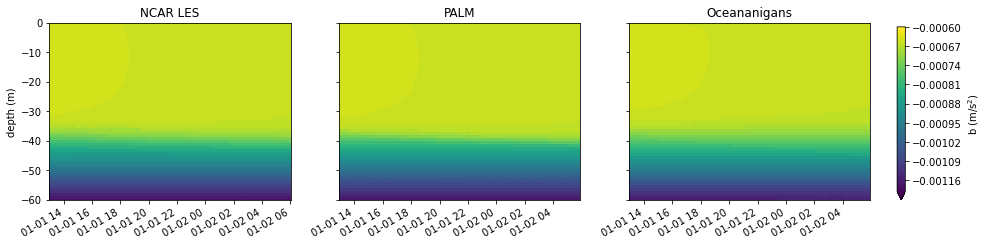

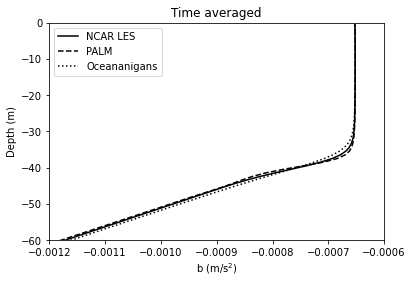

In [6]:
var = 'b'
units = 'm/s$^2$'
levels = np.linspace(-1.2e-3, -0.6e-3, 61)
# levels = None
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='viridis')

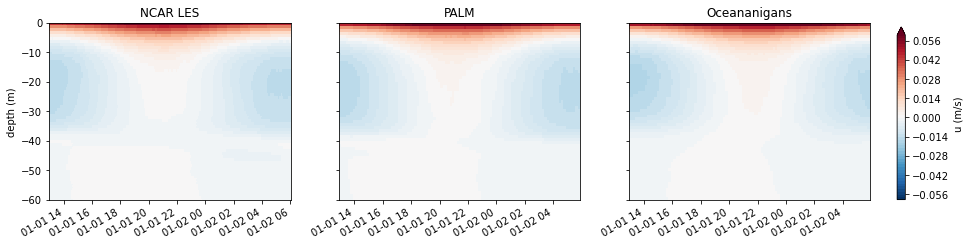

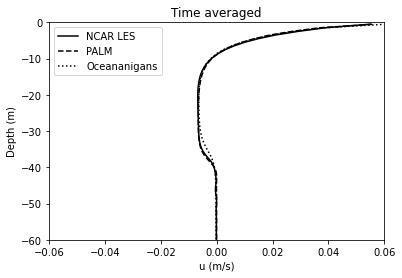

In [7]:
var = 'u'
units = 'm/s'
levels = np.linspace(-0.06, 0.06, 61)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

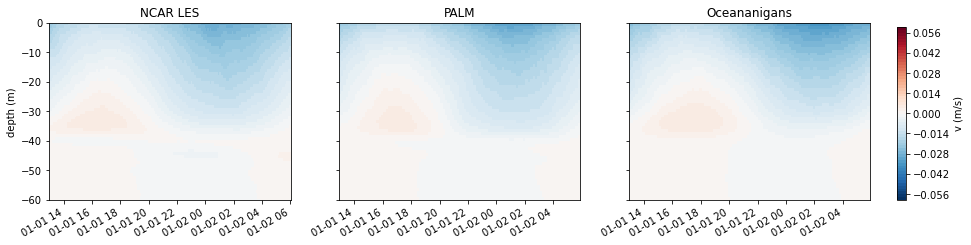

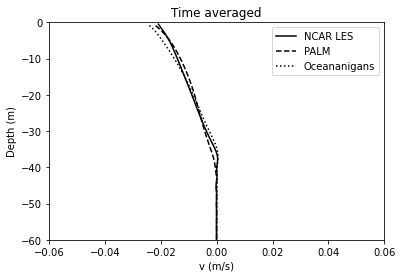

In [8]:
var = 'v'
units = 'm/s'
levels = np.linspace(-0.06, 0.06, 61)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

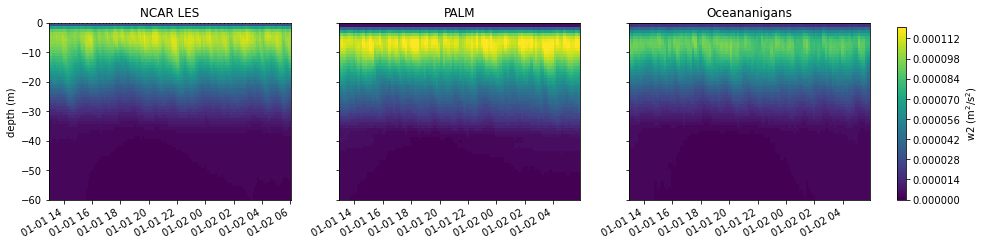

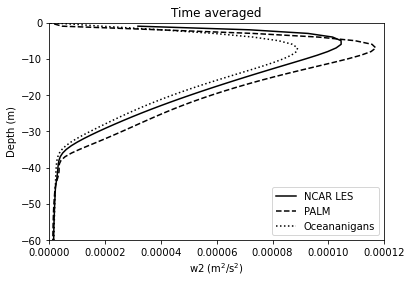

In [9]:
var = 'w2'
units = 'm$^2$/s$^2$'
levels = np.linspace(0, 1.2e-4, 61)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60)

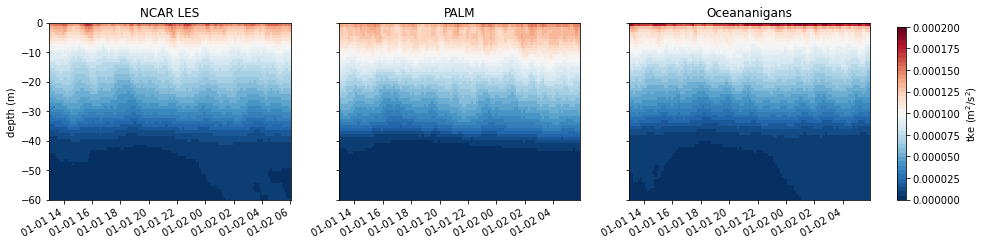

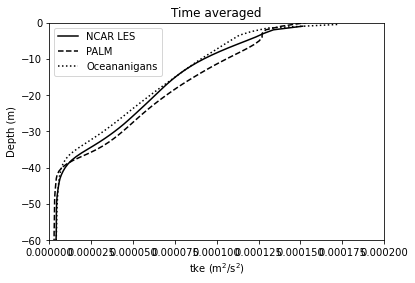

In [10]:
var = 'tke'
units = 'm$^2$/s$^2$'
levels = np.linspace(0, 2e-4, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

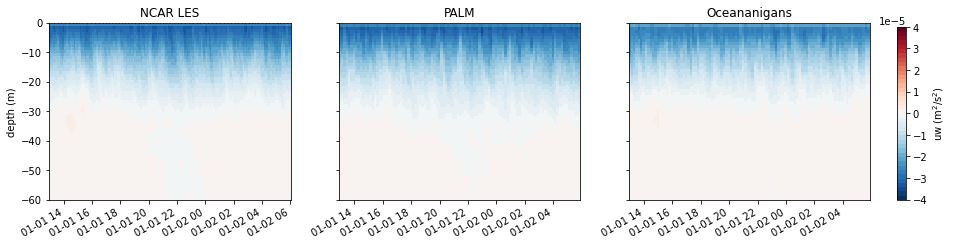

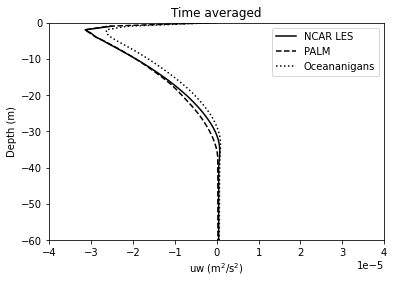

In [11]:
var = 'uw'
units = 'm$^2$/s$^2$'
levels = np.linspace(-4e-5, 4e-5, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

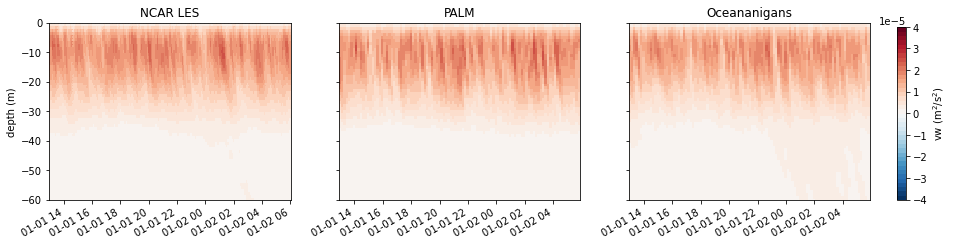

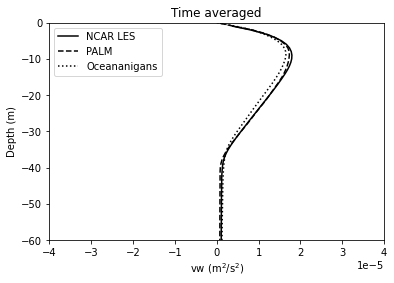

In [12]:
var = 'vw'
units = 'm$^2$/s$^2$'
levels = np.linspace(-4e-5, 4e-5, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

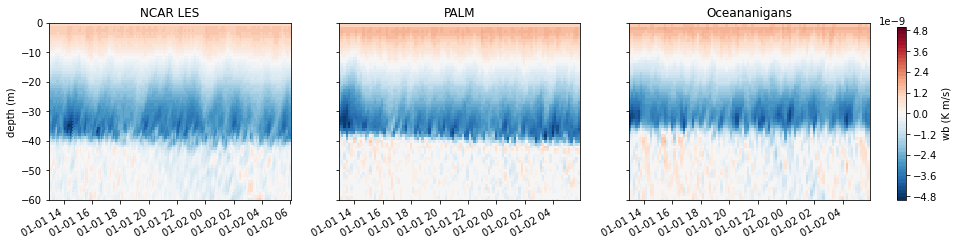

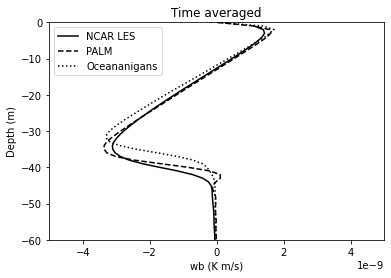

In [13]:
var = 'wb'
units = 'K m/s'
levels = np.linspace(-5e-9, 5e-9, 51)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60, cmap='RdBu_r')

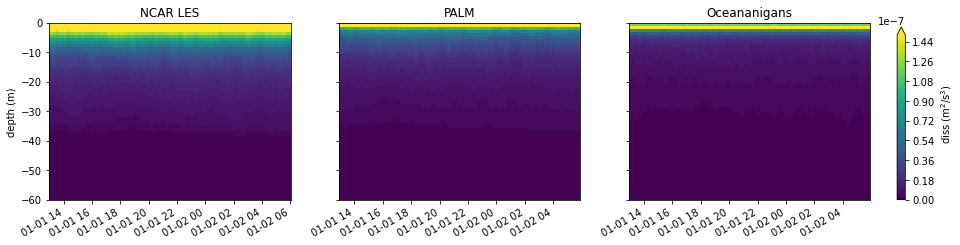

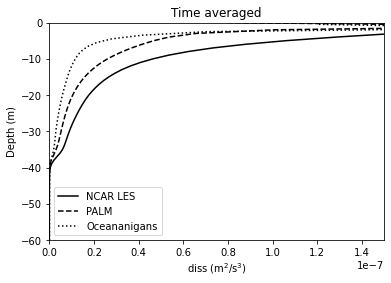

In [14]:
var = 'diss'
units = 'm$^2$/s$^3$'
levels = np.linspace(0, 1.5e-7, 51)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, depth=-60)